#### Manifold Learning
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high.

The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. Though this allows some degree of visualization of the data structure, the randomness of the choice leaves much to be desired. In a random projection, it is likely that the more interesting structure within the data will be lost.

To address this concern, a number of supervised (Linear Discriminant Analysis, Neighborhood Component Analysis) and unsupervised (Principal Component Analysis (PCA), Independent Component Analysis) linear dimensionality reduction frameworks have been designed. These algorithms define specific rubrics to choose an “interesting” linear projection of the data. These methods can be powerful, but often miss important non-linear structure in the data.

The RandomTreesEmbedding, from the sklearn.ensemble module, is not technically a manifold embedding method, as it learn a high-dimensional representation on which we apply a dimensionality reduction method. However, it is often useful to cast a dataset into a representation in which the classes are linearly-separable.

t-SNE is usually initialized with the embedding that is generated by PCA to ensure global stability of the embedding, i.e., the embedding does not depend on random initialization.


In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection, neighbors)

In [3]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [4]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min) # normalize

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

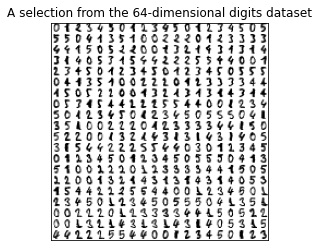

In [5]:
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')



Computing random projection


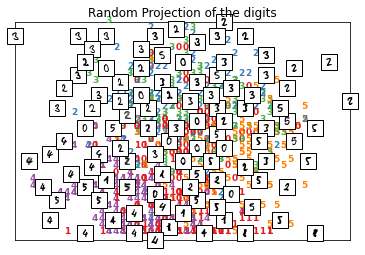

In [12]:
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

Computing PCA projection


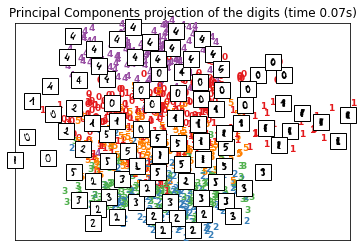

In [17]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, "Principal Components projection of the digits (time %.2fs)" % (time() - t0))

Computing Linear Discriminant Analysis projection


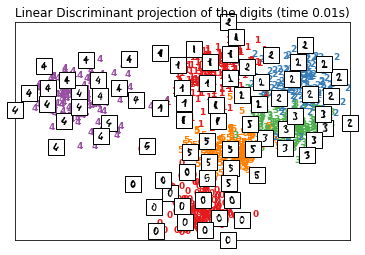

In [18]:
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, "Linear Discriminant projection of the digits (time %.2fs)" % (time() - t0))

One of the earliest approaches to manifold learning is the Isomap algorithm, short for Isometric Mapping. Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points.

Computing Isomap projection
Done.


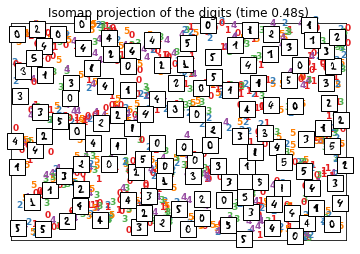

In [42]:
# Isomap projection of the digits dataset
print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,"Isomap projection of the digits (time %.2fs)" % (time() - t0))

Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.

In [ ]:
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle, "Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

One well-known issue with LLE is the regularization problem. When the number of neighbors is greater than the number of input dimensions, the matrix defining each local neighborhood is rank-deficient. To address this, standard LLE applies an arbitrary regularization parameter , which is chosen relative to the trace of the local weight matrix.

One method to address the regularization problem is to use multiple weight vectors in each neighborhood. This is the essence of modified locally linear embedding (MLLE). MLLE can be performed with function locally_linear_embedding or its object-oriented counterpart LocallyLinearEmbedding, with the keyword method = 'modified'. It requires n_neighbors > n_components.

In [ ]:
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle, "Modified Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

Hessian Eigenmapping (also known as Hessian-based LLE: HLLE) is another method of solving the regularization problem of LLE. It revolves around a hessian-based quadratic form at each neighborhood which is used to recover the locally linear structure. Though other implementations note its poor scaling with data size, sklearn implements some algorithmic improvements which make its cost comparable to that of other LLE variants for small output dimension. HLLE can be performed with function locally_linear_embedding or its object-oriented counterpart LocallyLinearEmbedding, with the keyword method = 'hessian'. It requires n_neighbors > n_components * (n_components + 3) / 2.

Computing Hessian LLE embedding
Done. Reconstruction error: 1.51285e-06


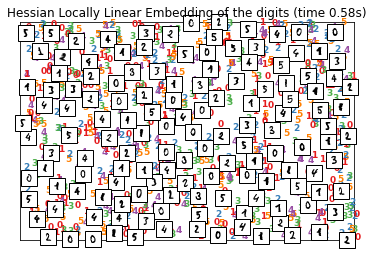

In [43]:
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle, "Hessian Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

Though not technically a variant of LLE, Local tangent space alignment (LTSA) is algorithmically similar enough to LLE that it can be put in this category. Rather than focusing on preserving neighborhood distances as in LLE, LTSA seeks to characterize the local geometry at each neighborhood via its tangent space, and performs a global optimization to align these local tangent spaces to learn the embedding. LTSA can be performed with function locally_linear_embedding or its object-oriented counterpart LocallyLinearEmbedding, with the keyword method = 'ltsa'.

Computing LTSA embedding
Done. Reconstruction error: 1.51285e-06


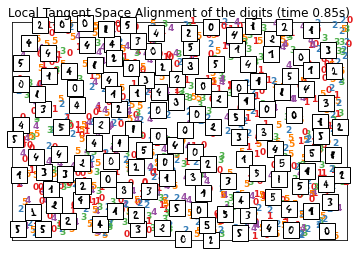

In [46]:
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa, "Local Tangent Space Alignment of the digits (time %.2fs)" % (time() - t0))

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In general, MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

There exists two types of MDS algorithm: metric and non metric. In the scikit-learn, the class MDS implements both. In Metric MDS, the input similarity matrix arises from a metric (and thus respects the triangular inequality), the distances between output two points are then set to be as close as possible to the similarity or dissimilarity data. In the non-metric version, the algorithms will try to preserve the order of the distances, and hence seek for a monotonic relationship between the distances in the embedded space and the similarities/dissimilarities.

In [ ]:
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, "MDS embedding of the digits (time %.2fs)" % (time() - t0))

Computing Totally Random Trees embedding


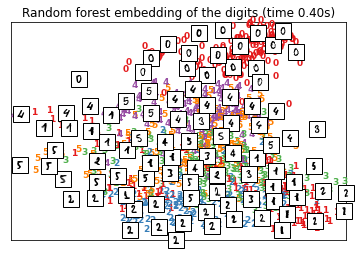

In [28]:
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Random forest embedding of the digits (time %.2fs)" % (time() - t0))

Spectral Embedding is an approach to calculating a non-linear embedding. Scikit-learn implements Laplacian Eigenmaps, which finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian. The graph generated can be considered as a discrete approximation of the low dimensional manifold in the high dimensional space. Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low dimensional space, preserving local distances. Spectral embedding can be performed with the function spectral_embedding or its object-oriented counterpart SpectralEmbedding.

Computing Spectral embedding


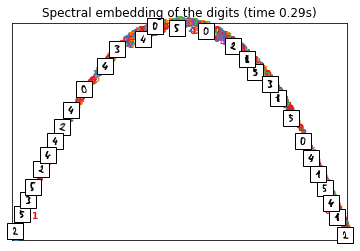

In [44]:
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)
plot_embedding(X_se, "Spectral embedding of the digits (time %.2fs)" % (time() - t0))

t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

Revealing the structure at many scales on a single map

Revealing data that lie in multiple, different, manifolds or clusters

Reducing the tendency to crowd points together at the center

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space will be minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence. Hence, it is sometimes useful to try different seeds and select the embedding with the lowest KL divergence.

The disadvantages to using t-SNE are roughly:

t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes

The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.

The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.

Global structure is not explicitly preserved. This problem is mitigated by initializing points with PCA (using init='pca')

Computing t-SNE embedding


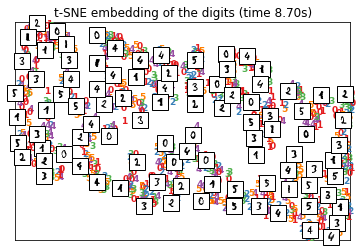

In [48]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" % (time() - t0))

Computing NCA projection


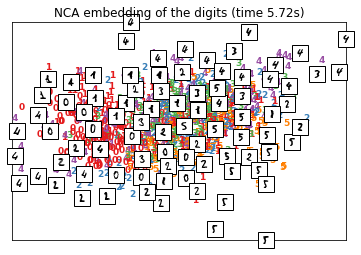

In [31]:
# NCA projection of the digits dataset
print("Computing NCA projection")
nca = neighbors.NeighborhoodComponentsAnalysis(init='random', n_components=2, random_state=0)
t0 = time()
X_nca = nca.fit_transform(X, y)

plot_embedding(X_nca, "NCA embedding of the digits (time %.2fs)" % (time() - t0))

plt.show()

MDS does not seeks an isotropic representation of the data in the low-dimensional space.

In [32]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

In [39]:
from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

/home/sod/PycharmProjects/scientific_python/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


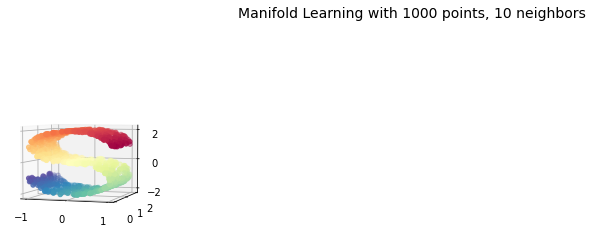

In [40]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding, n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca', random_state=0)


In [41]:
# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
plt.show()

LLE: 0.24 sec
LTSA: 0.46 sec
Hessian LLE: 0.49 sec
Modified LLE: 0.35 sec
Isomap: 0.59 sec
MDS: 3 sec
SE: 0.16 sec
t-SNE: 4.3 sec
